In [19]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
%matplotlib inline

torch.set_printoptions(threshold=100000)

In [20]:
raw_path = "../Cyclist_Detection/raw"

In [21]:
target_path = "../Cyclist_Detection/Dataset"

In [22]:
def yolo_load_data(path,target):
    """Used for loading .txt files with labels in the yolo format for object detection"""

    try:
        path_labels = os.path.join(path,"labels")
        labels_dir = sorted(os.listdir(path_labels))
    except:
        raise ValueError("The file has to be split into images and labels folders")


    for dir in labels_dir:
        with open(os.path.join(path_labels,dir),'r') as txt:
            txt_lines = txt.readlines()
            txt.close()

        single_yolo = torch.empty((len(txt_lines),5))

        for j in range(len(txt_lines)):
            txt_lines[j] = txt_lines[j].strip()
            single_line = torch.tensor(list(map(float,txt_lines[j].split(" "))))
            single_yolo[j] = single_line

        target_dir = dir.replace(".txt",".pt")

        target_labels = os.path.join(target,"labels")
        if not os.path.exists(target_labels):
            os.makedirs(target_labels)

        torch.save(single_yolo,os.path.join(target_labels,target_dir))

    try:
        path_images = os.path.join(path,"images")
        images_dir = sorted(os.listdir(path_images))
    except:
        raise ValueError("The file has to be split into images and labels folders")


    for dir in images_dir:
        img = torchvision.io.read_image(os.path.join(path_images,dir))

        target_dir = dir.replace(".jpg",".pt")

        target_images = os.path.join(target,"images")

        if not os.path.exists(target_images):
            os.makedirs(target_images)

        torch.save(img,os.path.join(target_images,target_dir))






In [23]:
yolo_load_data(raw_path,target_path)

In [175]:
img = torchvision.io.read_image("../Cyclist_Detection/raw/images/000000.jpg")
type(img)

torch.Tensor

In [ ]:
img = torchvision.transforms.ToPILImage()(img)

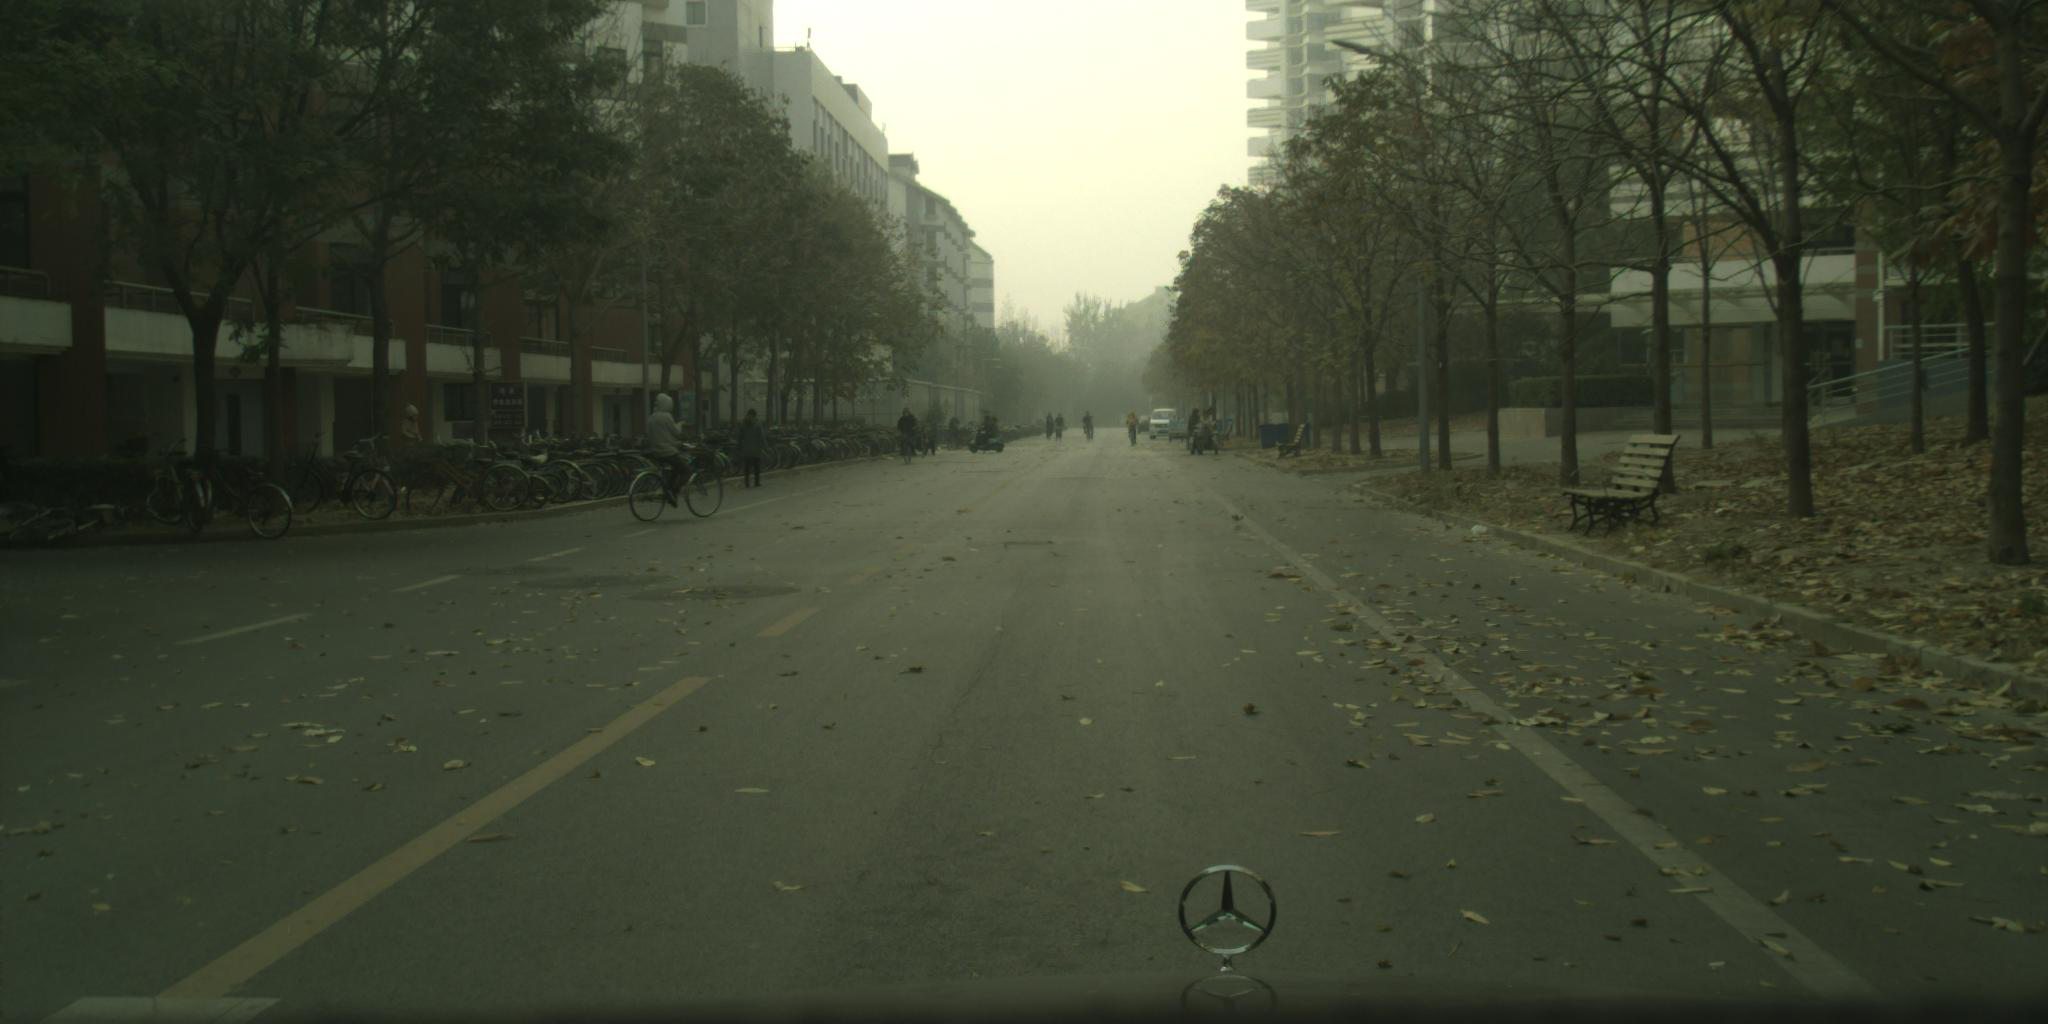

In [172]:
img